Step1 albert

In [1]:
import os
import cv2
import natsort
import numpy as np
# 設定輸入資料夾、輸出資料夾和新的尺寸
def resize_images(input_folder, output_folder, new_size, rename=True):
    # 讀取所有檔案
    files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif'))]
    # 使用 natsort 進行自然排序
    files = natsort.natsorted(files)
    # 依序處理檔案
    for i, filename in enumerate(files, 1):
        # 原始檔案路徑
        old_path = os.path.join(input_folder, filename)
        # 讀取圖片
        with open(old_path, 'rb') as f:
            img_array = np.asarray(bytearray(f.read()), dtype=np.uint8)
            image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        # 調整圖片大小
        resized_image = cv2.resize(image, new_size)
        # 根據是否重命名來決定新檔名
        if rename:
            new_filename = f"detect_{i+250}.png"
        else:
            new_filename = filename
        new_path = os.path.join(output_folder, new_filename)
        # 保存調整大小後的圖片
        cv2.imwrite(new_path, resized_image)
        print(f"已調整並保存: {filename} -> {new_filename}")
# 用戶輸入資料夾路徑
input_dir = input("輸入輸入資料夾路徑: ")
output_dir = input("輸入輸出資料夾路徑: ")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# 設定新尺寸
#new_size = (1038, 652)
new_size = (1280, 960)    
# 選擇是否需要重命名
rename_files = input("是否要重命名檔案？(Y/N): ").strip().lower() == 'y'
# 調整圖片大小並根據需要進行重命名
resize_images(input_dir, output_dir, new_size, rename=rename_files)
print("執行階段已結束")
print(f"輸入資料夾： {input_dir}")
print(f"輸出資料夾： {output_dir}")

輸入輸入資料夾路徑:  C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\raw
輸入輸出資料夾路徑:  C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\raw
是否要重命名檔案？(Y/N):  y


已調整並保存: raw_1.png -> detect_251.png
已調整並保存: raw_2.png -> detect_252.png
已調整並保存: raw_3.png -> detect_253.png
已調整並保存: raw_4.png -> detect_254.png
已調整並保存: raw_5.png -> detect_255.png
已調整並保存: raw_6.png -> detect_256.png
已調整並保存: raw_7.png -> detect_257.png
已調整並保存: raw_8.png -> detect_258.png
已調整並保存: raw_9.png -> detect_259.png
已調整並保存: raw_10.png -> detect_260.png
執行階段已結束
輸入資料夾： C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\raw
輸出資料夾： C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\raw


Step2.spilt_mask
    teeth_spilt.py

In [3]:
import cv2
import numpy as np
import os
import natsort  

def png_file_name_process(file_name): # png檔案名稱處理
    png_file_check = False
    if "color" in file_name and file_name.endswith(".png"):
        mask_name = file_name.replace("color_", "")  # 移除 "color_" 前綴
        png_file_check = True
    else:
        mask_name = file_name  # 如果不包含 "color_"，保持原始檔名    
    return mask_name, png_file_check

def inpaint_white_dots(image):
    """
    修復圖像中的白點。
    將圖像轉換為灰度圖，創建一個遮罩，並使用 inpaint 函數修復白點。
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.inRange(gray, 240, 255)
    result = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)
    return result

def retain_color(image, ranges, exclude_ranges=[]):
    """
    保留圖像中指定範圍內的顏色，並排除指定的顏色範圍。
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # 將圖像轉換為 HSV 色彩空間
    final_mask = np.zeros(hsv.shape[:2], dtype=np.uint8)  # 創建一個初始的空遮罩
    
    for lower_bound, upper_bound in ranges:
        mask = cv2.inRange(hsv, lower_bound, upper_bound)  # 創建遮罩，保留指定範圍內的顏色
        
        # 排除指定範圍的顏色
        for exclude_lower, exclude_upper in exclude_ranges:
            exclude_mask = cv2.inRange(hsv, exclude_lower, exclude_upper)
            mask = cv2.bitwise_and(mask, cv2.bitwise_not(exclude_mask))  # 排除指定範圍的顏色
        
        final_mask = cv2.bitwise_or(final_mask, mask)  # 合併遮罩
    
    # 應用形態學操作來清理遮罩
    kernel = np.ones((5, 5), np.uint8)
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, kernel)
    final_mask = cv2.dilate(final_mask, kernel, iterations=1)
    final_mask = cv2.erode(final_mask, kernel, iterations=1)
    
    result = np.zeros_like(image)  # 創建一個空的結果圖像
    result[final_mask != 0] = image[final_mask != 0]  # 將指定區域的顏色保留在結果圖像中
    result = cv2.GaussianBlur(result, (5, 5), 0)  # 對結果圖像進行高斯模糊處理
    return result

def remove_small_regions(binary_image, min_size):
    """
    移除二值圖像中小於指定大小的連通區域。
    """
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    new_image = np.zeros_like(binary_image)  # 創建一個新的二值圖像
    
    for i in range(1, num_labels):  # 跳過背景
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            new_image[labels == i] = 255  # 保留較大的區域
    
    return new_image

def fill_contours(binary_image):
    """
    對二值圖像中的輪廓進行洪水填充，確保內部區域被填充。
    """
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_image = np.zeros_like(binary_image)  # 創建一個新的空白圖像
    
    for contour in contours:
        cv2.drawContours(filled_image, [contour], -1, 255, thickness=cv2.FILLED)  # 填充輪廓內部
    
    return filled_image

def generate_and_process_masks(image, file_name):
    """
    根據不同的顏色範圍，生成牙齦、牙齒、牙冠和象牙質的遮罩，並轉換為二值遮罩。
    """
    # 定義區域的 HSV 範圍及對應的參數
    regions = {
        'gum': {'ranges': [(np.array([20, 78, 100]), np.array([35, 255, 255]))], 'exclude': []},
        'dentalcrown': {
            'ranges': [(np.array([152, 36, 90]), np.array([170, 150, 255]))], 
            'exclude': [
                (np.array([166, 84, 137]), np.array([151, 35, 89])),
                (np.array([156, 36, 32]), np.array([169, 117, 224])),
                (np.array([157, 52, 44]), np.array([165, 79, 90])),   
                (np.array([167, 35, 225]), np.array([168, 39, 244]))
            ]
        },
        'crown': {'ranges': [(np.array([0, 104, 102]), np.array([0, 253, 249]))], 'exclude': []},
        'dentin': {
            'ranges': [
                (np.array([92, 37, 50]), np.array([118, 180, 255])),
                (np.array([167, 80, 165]), np.array([167, 167, 221])) 
            ], 
            'exclude': [(np.array([158, 76, 150]), np.array([166, 80, 165])),
                        (np.array([168,167,221]), np.array([170, 120, 220]))]
        }
    }

    # 生成遮罩
    for region, params in regions.items():
        result = retain_color(image, params['ranges'], params['exclude'])
        output_path = os.path.join(color_path_dict[region], f"{region}_{mask_name}")
        # cv2.imwrite(output_path, result)  # 彩色分割結果
        # 轉換為二值遮罩並保存
        gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        _, bw = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        bw = remove_small_regions(bw, 1500)
        bw = fill_contours(bw)  # 進行輪廓填充
        bw_output_path = os.path.join(bw_path_dict[f'{region}_bw'], f"{region}_{mask_name}")
        cv2.imwrite(bw_output_path, bw)


if __name__ == "__main__":
    """
    處理圖像，分離不同的牙齦、牙齒、牙冠和象牙質區域，並將結果保存。
    """
    # 手動輸入資料夾路徑
    desktop_path = input("請輸入圖片資料夾路徑：")

    if not os.path.exists(desktop_path):
        print("輸入的資料夾路徑無效，程式終止。")
        exit()

    # 設置各種結果保存的資料夾路徑
    color_path = os.path.join(desktop_path, "color")
    bw_path = os.path.join(desktop_path, "bw")

    color_path_key_list = ['gum', 'teeth', 'dentalcrown', 'dentin', 'crown']
    color_path_dict = {key: os.path.join(color_path, key) for key in color_path_key_list}
    
    bw_path_key_list = ['gum_bw', 'dentalcrown_bw', 'dentin_bw', 'crown_bw']
    bw_path_dict = {key: os.path.join(bw_path, key) for key in bw_path_key_list}
    
    os.makedirs(bw_path, exist_ok=True)
    for path in bw_path_dict.values():
        os.makedirs(path, exist_ok=True)
    # 依序處理資料夾中的每張圖片，並進行自然排序
    sorted_file_names = natsort.natsorted(os.listdir(desktop_path))
    for file_name in sorted_file_names:
        file_path = os.path.join(desktop_path, file_name)
        mask_name, png_file_check = png_file_name_process(file_name)
        if png_file_check:
            # 讀取 PNG 圖片
            image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)           
            # 生成分離遮罩並轉換為二值遮罩
            generate_and_process_masks(image, file_name)
            print(f"processing saved: {file_name}")
    print("ALL work done！")

請輸入圖片資料夾路徑： C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\color


processing saved: color_1.png
processing saved: color_2.png
processing saved: color_3.png
processing saved: color_4.png
processing saved: color_5.png
processing saved: color_6.png
processing saved: color_7.png
processing saved: color_8.png
processing saved: color_9.png
processing saved: color_10.png
ALL work done！


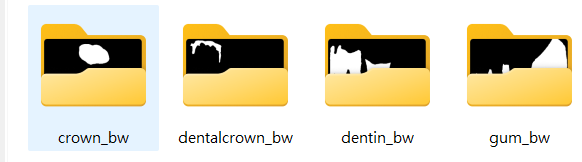

Step3.red_mark to excel
    analysis_to_excel.py

In [4]:
import os
import re
import pandas as pd
from tkinter import Tk , END
from PIL import Image, ImageTk, ImageDraw
from utils.UIHandler import UIHandler
from utils.FileHandler import FileHandler

class ImageCropper:
    def __init__(self, root, image_path):
        self.root = root  # 將 root 設置為類的屬性
        self.ui_handler = UIHandler(root)  # 創建 UI 處理器實例
        self.image_path = image_path
        self.image_files = FileHandler.get_image_files(os.path.dirname(image_path))  # 使用靜態方法獲取圖片文件
        self.current_image_index = self.image_files.index(image_path)  # 設置當前圖片索引
        
        self.canvas = self.ui_handler.create_canvas()  # 創建畫布
        self.text_box = self.ui_handler.create_textbox_with_scrollbar()  # 創建文本框和滾動條
        
        self.load_image()  # 加載並顯示初始圖片
        self.root.bind("<Control-s>", self.save_image)  # 綁定 Ctrl+S 快捷鍵保存圖片
        self.root.bind("<Control-z>", self.undo_last_point)  # 綁定 Ctrl+Z 快捷鍵撤銷最後一個點
        self.root.bind("<Control-n>", self.load_next_image)  # 綁定 Ctrl+N 快捷鍵加載下一張圖片
        self.root.bind("<Control-b>", self.load_previous_image)  # 綁定 Ctrl+B 快捷鍵加載上一張圖片
        self.coords = []  # 初始化座標列表，用於存儲點擊的座標

    def load_image(self):
        """
        加載當前圖片並顯示在畫布上，更新窗口標題。
        """
        self.image = Image.open(self.image_files[self.current_image_index])  # 打開當前圖片
        max_width = 640  # 設置最大寬度
        max_height = 480  # 設置最大高度
        if self.image.width > max_width or self.image.height > max_height:
            self.image.thumbnail((max_width, max_height), Image.LANCZOS)  # 如果圖片超過最大尺寸，則進行縮放
        
        self.photo = ImageTk.PhotoImage(self.image)  # 將圖片轉換為 Tkinter 可顯示的格式
        
        canvas_width = self.image.width
        canvas_height = self.image.height
        
        self.canvas.config(width=canvas_width, height=canvas_height)  # 設置畫布大小與圖片一致
        self.canvas.delete("all")  # 清空畫布
        
        self.canvas.create_image(0, 0, anchor='nw', image=self.photo)  # 在畫布上顯示圖片
        
        self.canvas.bind("<Button-1>", self.get_click_coordinates)  # 綁定點擊事件，記錄點擊座標
        
        # 更新窗口標題為當前圖片名稱
        self.root.title(f"Image: {os.path.basename(self.image_files[self.current_image_index])}")

    def get_click_coordinates(self, event):
        """
        處理圖片上的點擊事件，記錄座標並顯示在畫布和文本框中。
        
        :param event: 點擊事件
        """
        x, y = event.x, event.y  # 獲取點擊的座標
        self.coords.append((x, y))  # 將座標添加到列表中
        
        img_width, img_height = self.image.size
        # 根據縮放比例計算實際圖片上的座標
        scaled_x = round(x * (1280 / img_width))
        scaled_y = round(y * (960 / img_height))
        
        self.text_box.insert(END, f'Click Point: ({scaled_x}, {scaled_y})\n')  # 在文本框中顯示座標
        
        radius = 3
        # 在畫布上標記紅點
        self.canvas.create_oval(x - radius, y - radius, x + radius, y + radius, fill='red')

    def save_image(self, event=None):
        draw_image = self.image.copy()
        draw = ImageDraw.Draw(draw_image)
        original_width, original_height = draw_image.size
        scaled_coords = []
        for (x, y) in self.coords:
            scaled_x = round(x * (original_width / self.image.width))
            scaled_y = round(y * (original_height / self.image.height))
            draw.ellipse((scaled_x - 3, scaled_y - 3, scaled_x + 3, scaled_y + 3), fill='red', outline='red')
            scaled_coords.append((scaled_x, scaled_y))
        
        image_filename = os.path.basename(self.image_files[self.current_image_index])
        image_number = re.findall(r'\d+', image_filename)
        if image_number:
            image_number = image_number[0]
        else:
            image_number = "0"
        
        save_path = os.path.join(os.path.dirname(self.image_files[self.current_image_index]),"redmark", f"redmark_{image_number}.png") # 標記後圖片儲存路徑
        excel_path = os.path.join(os.path.dirname(self.image_files[self.current_image_index]),"analysis",  f"analysis_{image_number}.xlsx") # Excel儲存路徑
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        os.makedirs(os.path.dirname(excel_path), exist_ok=True)
        # 檢查是否存在相同名稱的檔案
        if os.path.exists(save_path) or os.path.exists(excel_path):
            answer = ui_handler.askyesno("File Already Exists", f'File {save_path}\n or {excel_path} already exists. Overwrite?')
            if not answer:    
                return
                # 如果不重覆儲存則結束程式
        
        draw_image = draw_image.resize((1280, 960), Image.LANCZOS) # 調整保存的圖片大小
        draw_image.save(save_path)
        
        # Excel的欄位名稱
        columns = [
            '牙齒ID（相對該張影像的順序ID即可、從左至右）',
            '牙尖ID（從左側至右側，看是連線到哪一個牙尖端）',
            '珐瑯質跟象牙質交接點x',
            '珐瑯質跟象牙質交接點y',
            '牙齦交接點x',
            '牙齦交接點y',
            '牙本體尖端點x',
            '牙本體尖端點y',
            '長度',
            'stage'
        ]
        
        df = pd.DataFrame(columns=columns)

        rows = []
        for i in range(0, len(scaled_coords), 3):
            # 跟 Columns 對應
            row = [None] * len(columns)
            if i < len(scaled_coords):
                row[2] = 2*scaled_coords[i][0]
                row[3] = 2*scaled_coords[i][1]
            if i + 1 < len(scaled_coords):
                row[4] = 2*scaled_coords[i + 1][0]
                row[5] = 2*scaled_coords[i + 1][1]
            if i + 2 < len(scaled_coords):
                row[6] = 2*scaled_coords[i + 2][0]
                row[7] = 2*scaled_coords[i + 2][1]
            rows.append(row)
        
        df = pd.concat([df, pd.DataFrame(rows, columns=columns)], ignore_index=True)
        
        with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
            df.to_excel(writer, index=False, header=True)
            
            worksheet = writer.sheets['Sheet1']
            for i, col in enumerate(df.columns):
                max_len = max(df[col].astype(str).map(len).max(), len(col)) + 13 # 設定最大長度
                worksheet.set_column(i, i, max_len)
            
            workbook = writer.book
            cell_format = workbook.add_format({'bold': False})
            for col_num, value in enumerate(df.columns.values):
                worksheet.write(0, col_num, value, cell_format)
        
        self.ui_handler.show_info("Success Saved Image", f'Image saved as: \n{save_path}\nCoordinates saved as: \n{excel_path}')
        print(f'Image saved as: {save_path}')       # 顯示圖片和座標檔案已儲存的提示
        print(f'Coordinates saved as: {excel_path}') # 並在控制台輸出儲存的檔案路徑

        
    def undo_last_point(self, event=None):
        """
        撤銷最後一個標記點，並在畫布上重新繪製其餘標記點。
        
        :param event: 鍵盤事件，默認為 None
        """
        if self.coords:
            self.coords.pop()  # 刪除最後一個座標
            self.text_box.delete("end-2l", "end-1l")  # 從文本框中刪除最後一行
            self.canvas.delete("all")  # 清空畫布
            self.canvas.create_image(0, 0, anchor='nw', image=self.photo)  # 重新加載圖片
            radius = 3
            for x, y in self.coords:
                self.canvas.create_oval(x - radius, y - radius, x + radius, y + radius, fill='red')  # 重新繪製剩餘的標記點

    def load_next_image(self, event=None):
        """
        加載目錄中的下一張圖片，並顯示提示訊息。
        
        :param event: 鍵盤事件，默認為 None
        """
        next_image_index = self.current_image_index + 1
        if next_image_index >= len(self.image_files):
            self.ui_handler.show_info("No More Images", "No more images to load")
            return
        self.coords = []  # 清空當前座標
        self.text_box.delete(1.0, END)  # 清空文本框
        self.current_image_index = next_image_index  # 更新圖片索引
        self.image_path = self.image_files[self.current_image_index]  # 更新當前圖片路徑
        self.load_image()  # 加載並顯示新圖片
        self.ui_handler.show_info("Next Image", f'Load image: {self.image_files[self.current_image_index]}')

    def load_previous_image(self, event=None):
        """
        加載目錄中的上一張圖片，並顯示提示訊息。
        
        :param event: 鍵盤事件，默認為 None
        """
        previous_image_index = self.current_image_index - 1
        if previous_image_index < 0:
            self.ui_handler.show_info("No More Images", "No more previous images to load")
            return
        self.coords = []  # 清空當前座標
        self.text_box.delete(1.0, END)  # 清空文本框
        self.current_image_index = previous_image_index  # 更新圖片索引
        self.image_path = self.image_files[self.current_image_index]  # 更新當前圖片路徑
        self.load_image()  # 加載並顯示新圖片
        self.ui_handler.show_info("Previous Image", f'Load image: {self.image_files[self.current_image_index]}')

if __name__ == "__main__":
    root = Tk()
    root.withdraw()
    ui_handler = UIHandler(root)  # 創建 UI 處理器實例
    image_path = ui_handler.prompt_for_image_path()  # 提示用戶輸入圖片路徑

    if image_path:
        if os.path.isfile(image_path):
            root.deiconify()
            app = ImageCropper(root, image_path)
            app.ui_handler.show_help()  # 在確認圖片路徑後顯示幫助視窗
            root.mainloop()
        else:
            ui_handler.show_error("Error", "Image file not found")
    else:
        ui_handler.show_info("Cancelled", "No image path provided")

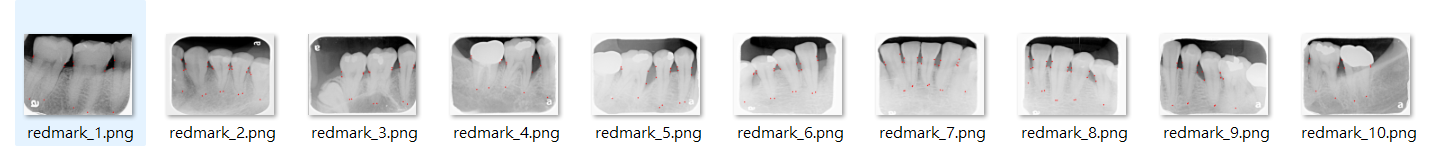

step4.分類檔案

In [6]:
import os
import shutil
import re

def copy_and_sort_files(input_dir, output_dir):
    # 如果目標資料夾不存在，創建它
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    print(f'目標資料夾：{output_dir}')
    
    # 遍歷input_dir中的所有子資料夾和檔案
    for root, dirs, files in os.walk(input_dir):
        print(f'正在處理目錄：{root}')
        for file in files:
            print(f'發現檔案：{file}')
            # 提取檔案名稱中的數字部分
            match = re.search(r'(\d+)', file)  # 使用 re.search 來匹配檔案名稱中的任何數字部分
            if match:
                folder_name = match.group(1)
                folder_path = os.path.join(output_dir, folder_name)
                # 如果分類資料夾不存在，創建它
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)
                    print(f'創建資料夾：{folder_path}')
                # 檢查目標資料夾中是否已經存在同名檔案
                destination_file_path = os.path.join(folder_path, file)
                if os.path.exists(destination_file_path):
                    print(f'檔案已存在，跳過：{destination_file_path}')
                    continue
                # 複製檔案到相應的分類資料夾中
                file_path = os.path.join(root, file)
                shutil.copy(file_path, folder_path)
                print(f'複製檔案：{file_path} 到 {folder_path}')
            else:
                print(f'無法匹配檔案名稱中的數字：{file}')
# 使用例子
input_dir = input("輸入輸入資料夾路徑: ")
#output_dir = input("輸入輸出資料夾路徑: ")
output_dir = os.path.join(input_dir, "spilt")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print('開始執行')
copy_and_sort_files(input_dir, output_dir)
print('執行完成')

輸入輸入資料夾路徑:  C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img


開始執行
目標資料夾：C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\spilt
正在處理目錄：C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img
正在處理目錄：C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\color
發現檔案：color_1.png
創建資料夾：C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\spilt\1
複製檔案：C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\color\color_1.png 到 C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\spilt\1
發現檔案：color_10.png
創建資料夾：C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\spilt\10
複製檔案：C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\color\color_10.png 到 C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\spilt\10
發現檔案：color_2.png
創建資料夾：C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\spilt\2
複製檔案：C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\color\color_2.png 到 C:\Users\SSTek\Desktop\LianChia\0916-20\final\task1\test_img\spilt\2
發現檔案：color_3.png
創建資料夾：C:\Users\SST

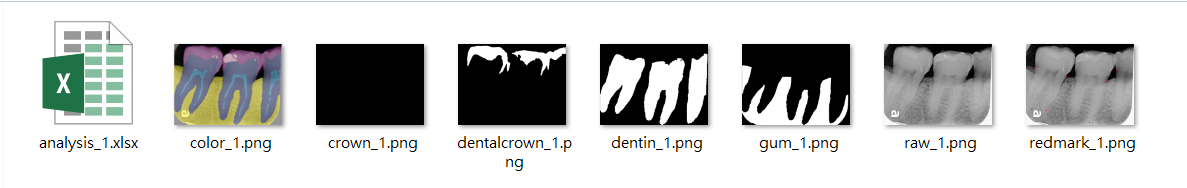